## Pamiątka (*ang. Memento*)

**Typ**: behawioralny \
**Zakres**: obiektowy  
**Inna nazwa**: Snapshot

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>pamiątka</b> bez naruszenia kapsułkowania rejestruje i zapisuje w zewnętrznej jednostce wewnętrzny stan obiektu, co umożliwia póniejsze przywrócenie obiektu według zapamiętanego stanu.
</div>

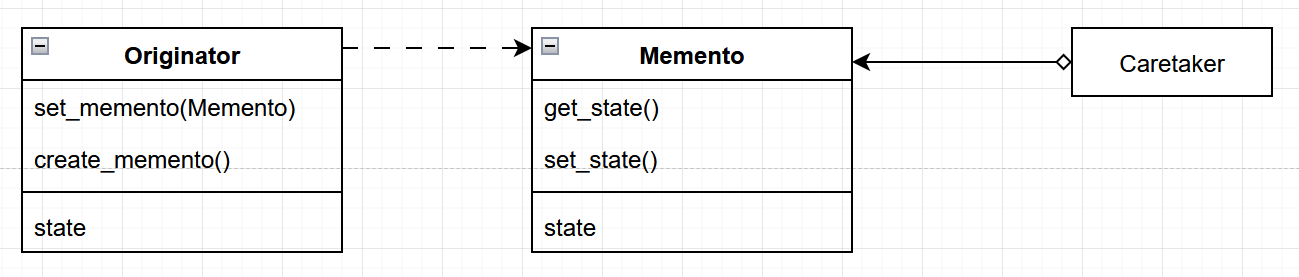

### Problem - zapisywanie stanu bez ujawniania szczegółów

Edytor tekstu musi obsługiwać **undo** - cofanie do poprzedniego stanu.

**Problem:**
- Jak zapisać stan obiektu (tekst, kursor, formatowanie)?
- Jak przywrócić stan?
- Jak NIE naruszyć hermetyzacji (nie ujawniać pól prywatnych)?

### Naiwne podejście - publiczny dostęp do stanu

In [ ]:
class Editor:
    def __init__(self):
        self.text = ""        # ❌ Publiczne pole
        self.cursor = 0       # ❌ Publiczne pole
    
    def write(self, text):
        self.text += text
        self.cursor = len(self.text)
        print(f"📝 '{self.text}' (kursor: {self.cursor})")


class History:
    def __init__(self):
        self.states = []  # Lista (text, cursor)
    
    def save(self, editor):
        # ❌ Bezpośredni dostęp do pól!
        self.states.append((editor.text, editor.cursor))
    
    def undo(self, editor):
        if self.states:
            text, cursor = self.states.pop()
            # ❌ Bezpośrednie ustawianie pól!
            editor.text = text
            editor.cursor = cursor
            print(f"⏪ Przywrócono: '{editor.text}'")

In [ ]:
editor = Editor()
history = History()

history.save(editor)
editor.write("Hello")

history.save(editor)
editor.write(" World")

print("\n=== UNDO ===")
history.undo(editor)

**Problemy:**
- ❌ **Złamanie hermetyzacji** - `History` zna pola prywatne `Editor`
- ❌ **Sztywne powiązanie** - dodanie nowego pola w klasie `Editor` wymusza wprowadzenie zmian w klasie `History`
- ❌ **Brak kontroli** - każdy może modyfikować `editor.text` bezpośrednio
- ❌ `Editor` nie kontroluje **co** jest zapisywane

### Rozwiązanie - wzorzec Pamiątka

**Idea:** `Editor` tworzy **Memento** (snapshot stanu). `History` przechowuje Memento **bez dostępu** do jego wnętrza.

### Krok 1: Memento - przechowuje stan

In [ ]:
class EditorMemento:
    """Pamiątka - przechowuje stan Editora"""
    
    def __init__(self, text: str, cursor: int):
        # Pola prywatne, tylko pamiątka ma dostęp (ustawia je Editor tworząc pamiątkę)
        self._text = text
        self._cursor = cursor

    # gettery
    def get_text(self) -> str:
        return self._text
    
    def get_cursor(self) -> int:
        return self._cursor

### Krok 2: Originator (Editor) - tworzy i przywraca Memento

In [ ]:
class Editor:
    """Originator - tworzy i przywraca pamiątki"""
    
    def __init__(self):
        self._text = ""      # ✅ Prywatne
        self._cursor = 0     # ✅ Prywatne
    
    def write(self, text: str):
        self._text += text
        self._cursor = len(self._text)
        print(f"📝 '{self._text}' (kursor: {self._cursor})")
    
    # ════════════════════════════════════════════════════════════
    # Tworzenie pamiątki - tylko Editor zna swój stan
    # ════════════════════════════════════════════════════════════
    def save(self) -> EditorMemento:
        """Tworzy snapshot aktualnego stanu"""
        return EditorMemento(self._text, self._cursor)
    
    # ════════════════════════════════════════════════════════════
    # Przywracanie z pamiątki
    # ════════════════════════════════════════════════════════════
    def restore(self, memento: EditorMemento):
        """Przywraca stan z pamiątki"""
        self._text = memento.get_text()
        self._cursor = memento.get_cursor()
        print(f"⏪ Przywrócono: '{self._text}'")

**Kluczowa zmiana:**
- `Editor` sam tworzy pamiątkę (`save()`) - **kontroluje co zapisać**
- `Editor` sam przywraca (`restore()`) - **kontroluje jak przywrócić**
- Pola prywatne (`_text`, `_cursor`) - **hermetyzacja zachowana**

### Krok 3: Caretaker (History) - zarządza pamiątkami

In [ ]:
class History:
    """Caretaker - przechowuje pamiątki (NIE ma dostępu do ich wnętrza)"""
    
    def __init__(self):
        self._mementos = []  # Lista EditorMemento
    
    def save(self, memento: EditorMemento):
        """Zapisz pamiątkę"""
        self._mementos.append(memento)
    
    def undo(self) -> EditorMemento:
        """Pobierz ostatnią pamiątkę"""
        if self._mementos:
            return self._mementos.pop()
        return None

**Caretaker:**
- Przechowuje pamiątki (`_mementos`)
- **NIE zna** struktury pamiątki (nie czyta `_text`, `_cursor`)
- Tylko zarządza stosem (save/undo)

### Krok 4: Użycie - hermetyzacja zachowana

In [ ]:
editor = Editor()
history = History()

# Stan początkowy
memo = editor.save()  # Editor tworzy pamiątkę
history.save(memo)  # pamiętkę zapisujemy do historii

editor.write("Hello")
history.save(editor.save())  # Zapisz stan

editor.write(" World")
history.save(editor.save())  # Zapisz stan

editor.write("!")

# Undo
print("\n=== UNDO ===")
memento = history.undo()
if memento:
    editor.restore(memento)  # Editor przywraca z pamiątki

memento = history.undo()
if memento:
    editor.restore(memento)

**Zalety:**
- ✅ **Hermetyzacja zachowana** - `History` nie zna pól `Editor`
- ✅ **Kontrola** - tylko `Editor` tworzy i przywraca pamiątki
- ✅ **Luźne powiązanie** - dodanie pola w `Editor` → zmiana tylko `save()`/`restore()`
- ✅ **Historia** - łatwe śledzenie stanów

## Struktura wzorca

**Elementy wzorca Pamiątka:**

1. **Memento** - `EditorMemento`
   - Przechowuje **snapshot** stanu Originator
   - **Niezmienialny** (immutable)
   - Może mieć **wąski interfejs** dla Caretaker (lub wcale)

2. **Originator** - `Editor`
   - Tworzy pamiątkę (`save()`) - zna swój stan
   - Przywraca z pamiątki (`restore()`) - wie jak przywrócić

3. **Caretaker** - `History`
   - Przechowuje pamiątki (stos/lista)
   - **NIE modyfikuje** ani **NIE bada** pamiątek
   - Zarządza historią (undo/redo)

**Kluczowa właściwość:**
> Caretaker przechowuje pamiątki **nie znając** ich struktury wewnętrznej

## Przykład 2 - Gra z checkpointami

In [ ]:
# ════════════════════════════════════════════════════════════
# Memento
# ════════════════════════════════════════════════════════════
class GameMemento:
    """Snapshot stanu gry"""
    
    def __init__(self, level: int, health: int, score: int):
        self._level = level
        self._health = health
        self._score = score
    
    def get_level(self) -> int:
        return self._level
    
    def get_health(self) -> int:
        return self._health
    
    def get_score(self) -> int:
        return self._score


# ════════════════════════════════════════════════════════════
# Originator
# ════════════════════════════════════════════════════════════
class Game:
    """Stan gry"""
    
    def __init__(self):
        self._level = 1
        self._health = 100
        self._score = 0
    
    def play(self):
        print(f"🎮 Poziom {self._level}, HP: {self._health}, Punkty: {self._score}")
    
    def level_up(self):
        self._level += 1
        self._score += 100
        print(f"⬆️  Nowy poziom: {self._level}")
    
    def take_damage(self, damage: int):
        self._health -= damage
        print(f"💔 Obrażenia: {damage}, HP: {self._health}")
    
    # Tworzenie pamiątki
    def save(self) -> GameMemento:
        """Checkpoint - zapisz stan"""
        print(f"💾 Checkpoint: Poziom {self._level}")
        return GameMemento(self._level, self._health, self._score)
    
    # Przywracanie z pamiątki
    def restore(self, memento: GameMemento):
        """Wczytaj checkpoint"""
        self._level = memento.get_level()
        self._health = memento.get_health()
        self._score = memento.get_score()
        print(f"⏪ Wczytano: Poziom {self._level}")


# ════════════════════════════════════════════════════════════
# Caretaker
# ════════════════════════════════════════════════════════════
class SaveManager:
    """Zarządza zapisami gry"""
    
    def __init__(self):
        self._saves = {}  # {slot: memento}
    
    def save_game(self, slot: int, memento: GameMemento):
        self._saves[slot] = memento
        print(f"💾 Zapisano w slocie {slot}")
    
    def load_game(self, slot: int) -> GameMemento:
        if slot in self._saves:
            print(f"📂 Wczytuję slot {slot}")
            return self._saves[slot]
        return None

In [ ]:
game = Game()
save_manager = SaveManager()

# Rozgrywka
game.play()
game.level_up()

# Checkpoint
save_manager.save_game(slot=1, memento=game.save())

# Dalej gramy
game.level_up()
game.take_damage(50)
game.play()

# Kolejny checkpoint
save_manager.save_game(2, game.save())

# Przegrywamy
game.take_damage(100)

# Wczytujemy checkpoint
print("\n=== WCZYTYWANIE ===")
memento = save_manager.load_game(1)
if memento:
    game.restore(memento)
    game.play()

**Zastosowanie:**
- Checkpointy w grach
- Sloty zapisów (save slot 1, 2, 3...)
- SaveManager nie zna szczegółów stanu gry

## Kiedy używać wzorca Pamiątka?

Wzorzec Pamiątka stosuj gdy:

1. **Potrzebujesz zapisać/przywrócić stan obiektu**
   - Undo/Redo
   - Checkpointy
   - Snapshoty

2. **Bezpośredni dostęp do stanu narusza hermetyzację**
   - Nie chcesz ujawniać pól prywatnych
   - Stan jest złożony

3. **Obiekt sam wie jak zapisać/przywrócić swój stan**
   - Nie chcesz żeby ktoś inny znał szczegóły

**Przykłady praktyczne:**
- Edytory tekstu (undo/redo)
- Gry (checkpointy, save/load)
- Transakcje (rollback)
- IDE (history, revert)
- Grafika (historia zmian w Photoshop)
- Formularze (reset do początkowego stanu)

## Pamiątka vs Polecenie

**Oba wspierają undo, ale:**

| Aspekt | Pamiątka | Polecenie |
|--------|----------|----------|
| **Zapisuje** | Stan obiektu (snapshot) | Operację (akcję) |
| **Undo** | Przywraca cały stan | Cofa operację (odwrotna akcja) |
| **Pamięć** | ⚠️ Może być duża (cały stan) | ✅ Mniejsza (tylko parametry) |
| **Hermetyzacja** | ✅ Zachowana | ✅ Zachowana |

**Pamiątka:**
```python
memento = editor.save()  # Zapisuje cały stan (text="Hello", cursor=5)
editor.restore(memento)  # Przywraca cały stan
```

**Polecenie:**
```python
command = WriteCommand(editor, "Hello")  # Zapisuje operację
command.execute()  # Dodaje "Hello"
command.undo()     # Usuwa "Hello" (odwrotna operacja)
```

**Kiedy co:**
- **Pamiątka:** Stan jest prosty, całkowite przywrócenie
- **Polecenie:** Wiele małych operacji, operacje odwracalne

## Podsumowanie

Wzorzec Pamiątka:
- ✅ **Zachowuje hermetyzację** - Caretaker nie zna szczegółów stanu
- ✅ **Snapshot stanu** - łatwe przywracanie
- ✅ **Kontrola** - tylko Originator wie co zapisać
- ✅ **Historia** - łatwe śledzenie zmian
- ⚠️ **Pamięć** - może być kosztowne (wiele snapshots)
- ⚠️ **Serializacja** - trudne dla złożonych stanów

**Kluczowa idea:**
> **Snapshot stanu** jako obiekt - Originator tworzy, Caretaker przechowuje (nie czytając)

**Struktura:**
```python
# Memento
class Memento:
    def __init__(self, state):
        self._state = state  # Prywatny stan
    
    def get_state(self):
        return self._state

# Originator
class Originator:
    def save(self) -> Memento:
        return Memento(self._state)  # Tworzy snapshot
    
    def restore(self, memento: Memento):
        self._state = memento.get_state()  # Przywraca

# Caretaker
class Caretaker:
    def __init__(self):
        self._mementos = []
    
    def save(self, memento):
        self._mementos.append(memento)  # Tylko przechowuje
    
    def undo(self):
        return self._mementos.pop()  # Zwraca (nie czyta!)
```

**Istota wzorca:**
- **Enkapsulacja stanu:** Memento przechowuje snapshot (bez ujawniania szczegółów)
- **Originator kontroluje:** Tylko on wie co zapisać i jak przywrócić
- **Caretaker zarządza:** Przechowuje pamiątki nie znając ich wnętrza
- **Hermetyzacja:** Pola prywatne Originator pozostają prywatne

**Przepływ:**
1. Originator tworzy Memento (`save()`)
2. Caretaker przechowuje Memento (stos/lista)
3. Caretaker zwraca Memento (`undo()`)
4. Originator przywraca stan (`restore(memento)`)